## __SENTIMENT ANALYSIS IMPLEMENTATION__<hr>

### Import Libraries<hr>
We will use *pandas* and *numpy* for data manipulation, *nltk* for NLP, *matplotlib*, *seaborn*, and *plotly* for data visualization, *sklearn* and *keras* for training the model.

In [1]:
import pandas as pd
import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import stopwordsiso as stopwords
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf
import ipynb.fs.defs.preprocessing as prep
py.init_notebook_mode(connected=True)
%matplotlib inline

### Setting the Random Seed<hr>
This is to make the output of the models more consistent with the given inputs

In [2]:
# import os
# import random

# seed = 3000
# os.environ['PYTHONHASHSEED']=str(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# random.seed(seed)

### Load the dataset<hr>
We note that we have 500 entries for twitter (tweets) and facebook (posts and commments).

In [3]:
twitter = pd.read_csv('../data/twitter.csv', usecols=[0,4])
facebook = pd.read_csv('../data/facebook.csv', usecols=[0,4])
rand = pd.read_csv('../data/random.csv', usecols=[0,4])
df = pd.concat([twitter, facebook, rand])
df = shuffle(df)
df.head()

,Raw,Tag
694,Puro kain ako ngayong araw Anong meron,0
956,Wait Ano ba meaning ng virgin nga kasi,1
173,Boring mo naman,1
146,dapat pala nag mall ako bago umuwi hay,0
298,hindot,1


### Data Analysis - Statistics
In the next 2 cells, we examine the shape of our dataset and check if there are some missing values.

In [4]:
print(twitter.shape)
print(facebook.shape)
print(rand.shape)
print(df.shape)

(817, 2)
(501, 2)
(1010, 2)
(2328, 2)


we check for missing values using __isna()__:

In [5]:
# No missing values
twitter[twitter.isna().any(axis=1)]
facebook[facebook.isna().any(axis=1)]
rand[rand.isna().any(axis=1)]
df[df.isna().any(axis=1)]

,Raw,Tag


### Statistic<hr>
We note that we have 817 entries for twitter (tweets), 501 entries for facebook (posts and commments), and 1010 entries from mix of these social media sites.

length of all sentences in dataset and statistic:

In [6]:
lens = df['Raw'].str.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())

58.266323024054984 48.68624225250023 2 432


Distribution of tweets and post length:

In [7]:
data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=10), marker=dict(color='#8c42f4'))]
layout = go.Layout(
                  title='Length of tweets and post distribution',                  
                  xaxis=dict(title='Length'),
                  yaxis=dict(title='Count'),
                  bargap=0.1)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='length histogram')

Correlate length and sentiment marks:

In [8]:
df['Text_Length'] = df['Raw'].apply(lambda x: len(x))
data = df.sort_values(by='Text_Length')
plot = go.Scatter(x = data['Text_Length'], y = data['Tag'], mode='markers')
lyt = go.Layout(title="Length vs. Sentiment Label", xaxis=dict(title='Review Length'),yaxis=dict(title='Label'))
fig = go.Figure(data=[plot], layout=lyt)
py.iplot(fig)

Pearson correlation:

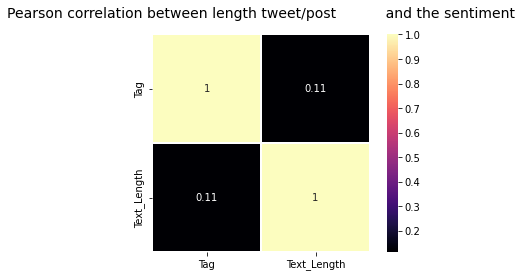

In [9]:
colormap = plt.cm.magma
plt.title('Pearson correlation between length tweet/post\
           and the sentiment', y=1.05, size=14)
sns.heatmap(data.drop(['Raw'], axis=1).astype(float).corr(),
            linewidths=0.01,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True)
plt.show()

#### Commonly seen words in one tag:

In [10]:
df_neg = df[ df['Tag'] == 1]
df_neg = df_neg['Raw']
df_pos = df[ df['Tag'] == 0]
df_pos = df_pos['Raw']

>Commonly seen in "__Negative__" sentences

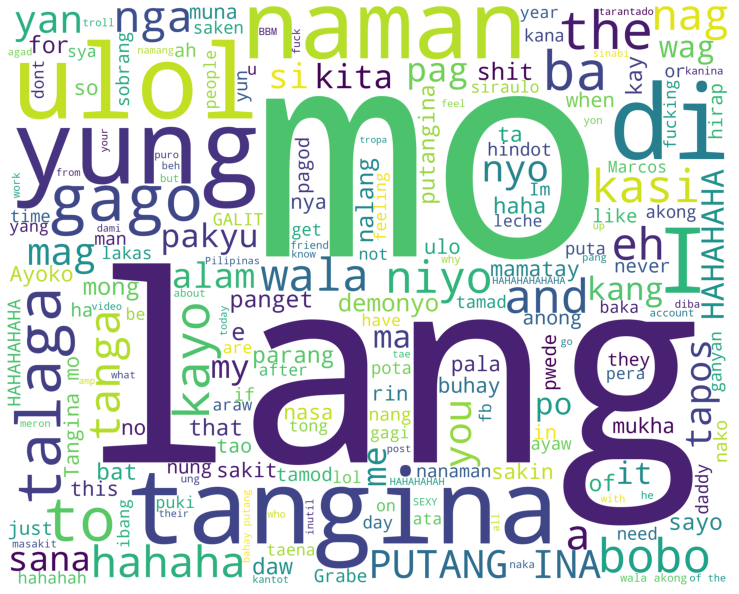

In [11]:
wordcloud1 = WordCloud(stopwords=stopwords.stopwords("tl"), # or STOPWORDS for eng
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

>Commonly seen in "__Positive__" sentences

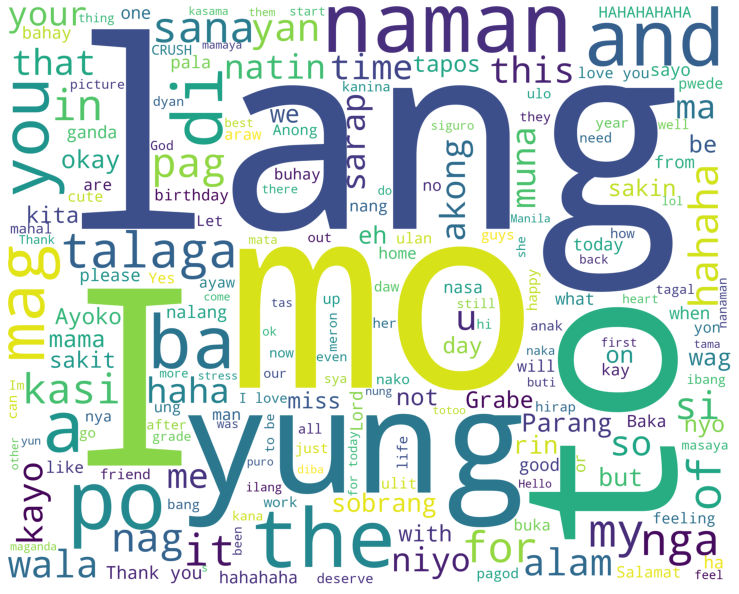

In [12]:
wordcloud2 = WordCloud(stopwords=stopwords.stopwords("tl"), # or STOPWORDS for eng
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))
plt.figure(2,figsize=(13, 13))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

#### Distribution of Sentiments:
We check the distribution of sentiments all throughout the data

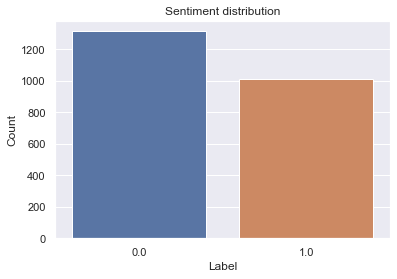

In [13]:
sns.set(style="darkgrid")
b = sns.countplot(x='Tag',
                  data = df.drop(['Raw'], axis=1).astype(float))
b.axes.set_title('Sentiment distribution')
b.set_xlabel("Label")
b.set_ylabel("Count")
plt.show()

### Text Preprocessing<hr>
Cleaning the text to remove punctuations, transform to lower case, remove emojis, remove hashtags, remove tags, and remove links:

In [14]:
df['Raw'] = df['Raw'].apply(prep.simplify_text)
df.head()

,Raw,Tag,Text_Length
694,puro kain ako ngayong araw anong meron,0,38
956,wait ano ba meaning ng virgin nga kasi,1,38
173,boring mo naman,1,15
146,dapat pala nag mall ako bago umuwi hay,0,38
298,hindot,1,6


Split for training and testing:

In [15]:
text = df['Raw']
tag = df['Tag']
text_train, text_test, tag_train, tag_test = train_test_split(text, tag, test_size=0.1)
print(text_train.shape,text_test.shape)

(2095,) (233,)


### __Naive Bayes__ - Training the Model<hr>
We use parameter $\text{min}_{\text{df}} = 2$ to filter out words that occur only once in the entire dataset.

In [16]:
vectorizer = TfidfVectorizer(min_df=2)
train_term = vectorizer.fit_transform(text_train)
test_term = vectorizer.transform(text_test)

Check words that will be used by the models as features:

In [17]:
vectorizer.get_feature_names_out()[100:120]

array(['asa', 'asan', 'asawa', 'ask', 'aso', 'asong', 'ass', 'asshole',
       'assuming', 'at', 'ata', 'ate', 'atleast', 'attack', 'attend',
       'attitude', 'australia', 'available', 'away', 'awit'], dtype=object)

We could then train the Naive Bayes Model:

In [18]:
model = MultinomialNB()
model.fit(train_term, tag_train)
predictions_train = model.predict(train_term)
predictions_test = model.predict(test_term)
print('Train Accuracy:', accuracy_score(tag_train, predictions_train))
print('Test Accuracy:', accuracy_score(tag_test, predictions_test))

Train Accuracy: 0.8892601431980907
Test Accuracy: 0.7939914163090128


### Checking for mistakes in the model<hr>
we use a confusion matrix for visualization.

Confusion matrix, without normalization
[[1160   28]
 [ 204  703]]
Confusion matrix, without normalization
[[118  10]
 [ 38  67]]


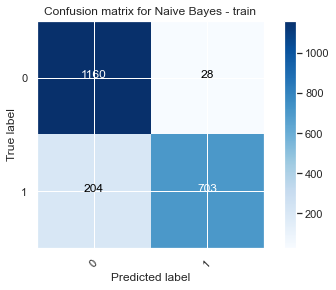

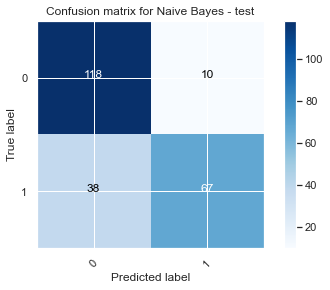

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix_train = confusion_matrix(tag_train, predictions_train)
cnf_matrix_test = confusion_matrix(tag_test, predictions_test)
plt.figure()
plot_confusion_matrix(cnf_matrix_train,
                      classes=[0,1],
                      title='Confusion matrix for Naive Bayes - train')
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='Confusion matrix for Naive Bayes - test')

### __LSTM__ - Training the Model<hr>
We use Long Short Term Memory Neural Network. We can then use a tokenizer (specifically the one in Keras: note that the other modules may have implementations of tokenizations themselves). We set the maximum feature size to about 3000.

In [20]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['Raw'].values)
text = tokenizer.texts_to_sequences(df['Raw'].values)
text = pad_sequences(text)

We can then build the model using the Keras library. First, we initialize the sequence model. Then, we add word embedding layer, lstm layer with 16 units and the fully connected (dense) layer with 1 (output) neuron with the sigmoid activation function. We use binary_crossentropy loss and Adam optimizer to train the model.

In [21]:
embed_dim = 64
lstm_out = 16
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=text.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(1,activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 81, 64)            192000    
                                                                 
 lstm (LSTM)                 (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 197,201
Trainable params: 197,201
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
tag = df['Tag'].values
text_train, text_test, tag_train, tag_test = train_test_split(text,tag, test_size = 0.1)
print(text_train.shape,tag_train.shape)
print(text_test.shape,tag_test.shape)

(2095, 81) (2095,)
(233, 81) (233,)


We train with a batch size of 16 and train for 10 epoch. The performance of the model is measured on the validation dataset.

In [23]:

batch_size = 16
model.fit(text_train,
          tag_train,
          epochs=6,
          batch_size=batch_size,
          validation_data=(text_test, tag_test),
          callbacks = [EarlyStopping(monitor='val_accuracy',
                       min_delta=0.001,
                       patience=10,
                       verbose=1)]
           )

Epoch 1/6
131/131 [==============================] - 4s 18ms/step - loss: 0.6567 - accuracy: 0.6033 - val_loss: 0.5957 - val_accuracy: 0.7597
Epoch 2/6
131/131 [==============================] - 2s 15ms/step - loss: 0.4210 - accuracy: 0.8215 - val_loss: 0.4667 - val_accuracy: 0.7682
Epoch 3/6
131/131 [==============================] - 2s 17ms/step - loss: 0.2359 - accuracy: 0.9103 - val_loss: 0.5003 - val_accuracy: 0.7597
Epoch 4/6
131/131 [==============================] - 2s 15ms/step - loss: 0.1522 - accuracy: 0.9456 - val_loss: 0.6127 - val_accuracy: 0.7296
Epoch 5/6
131/131 [==============================] - 2s 15ms/step - loss: 0.1146 - accuracy: 0.9628 - val_loss: 0.5909 - val_accuracy: 0.7682
Epoch 6/6
131/131 [==============================] - 2s 16ms/step - loss: 0.0823 - accuracy: 0.9737 - val_loss: 0.6248 - val_accuracy: 0.7725


Check the accuracy of predictions of the LSTM model:

In [24]:
predictions_nn_train = model.predict(text_train)
predictions_nn_test = model.predict(text_test)
for i in range(len(predictions_nn_train)):
    if predictions_nn_train[i][0] < 0.5:
        predictions_nn_train[i][0] = 0
    else:
        predictions_nn_train[i][0] = 1
        
for i in range(len(predictions_nn_test)):
    if predictions_nn_test[i][0] < 0.5:
        predictions_nn_test[i][0] = 0
    else:
        predictions_nn_test[i][0] = 1
print('Train accuracy:', accuracy_score(tag_train, predictions_nn_train))
print('Test accuracy', accuracy_score(tag_test, predictions_nn_test))

8/8 [==============================] - 0s 4ms/step
Train accuracy: 0.9799522673031026
Test accuracy 0.7725321888412017


Check the confusion matrix:

8/8 [==============================] - 0s 4ms/step
Confusion matrix, without normalization
[[1163    8]
 [  34  890]]
Confusion matrix, without normalization
[[112  33]
 [ 20  68]]


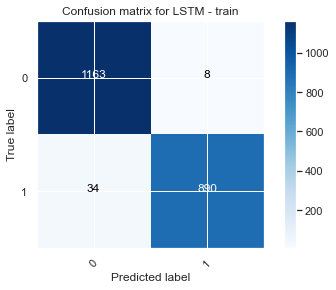

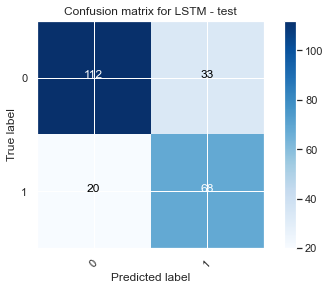

In [25]:
predictions_nn_train = model.predict(text_train)
predictions_nn_test = model.predict(text_test)

cnf_matrix_train = confusion_matrix(tag_train, predictions_nn_train.round())
cnf_matrix_test = confusion_matrix(tag_test, predictions_nn_test.round())

plt.figure()
plot_confusion_matrix(cnf_matrix_train,
                      classes=[0,1],
                      title='Confusion matrix for LSTM - train')
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='Confusion matrix for LSTM - test')

Compute the F1 score:

In [26]:
TP = cnf_matrix_test[0][0]
TN = cnf_matrix_test[1][1]
FP = cnf_matrix_test[1][0]
FN = cnf_matrix_test[0][1]
F1 = (TP+TN)/(TP+FP+TN+FN)
print(F1)

0.7725321888412017
